In [7]:
%load_ext autoreload
%autoreload 2

## To simplify headache, I define all things needed to be changed HERE

WORK_DIR = "/work/06782/ysu707/ls6/DAForLinGen"
CACHE_DIR = "/work/06782/ysu707/ls6/.cache"

# Load datasets of interest
from datasets import load_dataset, Dataset
import json

train_dataset_path = "/scratch/06782/ysu707/babylm_data/babylm_100M/aochildes.train"

datasets = load_dataset("text", data_files={"train": train_dataset_path}, cache_dir=CACHE_DIR)
train_dataset = datasets["train"]


eval_dataset_path = "/work/06782/ysu707/ls6/DAForLinGen/data/datasets/subject_verb_agreement/simple.json" 
with open(eval_dataset_path, "r") as handle:
    data = json.load(handle)

eval_dataset = Dataset.from_dict(
    {
        "text": [item["prompt"] for item in data],
        "completion": [item["completion"] for item in data],
    }
)

# Load Influence Scores
from kronfluence.analyzer import Analyzer
import torch

def load_scores(path: str):
    return Analyzer.load_file(path)

M = 10 # Number of top-k qualitative examples to show for each query
# Expect a {"module_name": torch.Tensor}
layers_path = "/scratch/06782/ysu707/babylm/full/scores_influence_scores_attn_correct/pairwise_scores.safetensors"
tensor_dict = load_scores(layers_path)
attn_scores = sum(tensor_dict.values()).to(torch.float32) # sum across all modules 
print("Influence score shape:", attn_scores.shape) # Expected: (eval_size, train_size)

train_dataset, eval_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Influence score shape: torch.Size([6, 763989])


(Dataset({
     features: ['text'],
     num_rows: 763989
 }),
 Dataset({
     features: ['text', 'completion'],
     num_rows: 6
 }))

In [11]:
from datasets import Dataset
import torch
import matplotlib.pyplot as plt

def sort_scores(scores: torch.Tensor, eval_idx: int):
    sorted_scores = torch.sort(scores[eval_idx], descending=True)
    return sorted_scores

def qualitative(scores: torch.Tensor, eval_dataset: Dataset, M: int):
    for eval_idx in range(len(eval_dataset)):
        sorted_scores = sort_scores(scores, eval_idx)
        top_indices = sorted_scores.indices
        
        plt.plot(sorted_scores.values)
        plt.grid()
        plt.ylabel("IF Score")
        plt.show()
        
        print("Query Sequence:")
        print(
            f"Text: {eval_dataset[eval_idx]['text']}\n"
        )
        print(
            f"Completion: {eval_dataset[eval_idx]['completion']}\n"
        )

        print("Top Positive Influential Sequences:")
        for i in range(M):
            print("=" * 80)
            print(
                f"Rank = {i}; Score = {scores[eval_idx][int(top_indices[i])].item()}"
            )
            print(train_dataset[int(top_indices[i])]["text"])
            
        print("Top Negative Influential Sequences:")
        for i in range(1, M+1):
            print("=" * 80)
            print(
                f"Rank = {-i}; Score = {scores[eval_idx][int(top_indices[-i])].item()}"
            )
            print(train_dataset[int(top_indices[-i])]["text"])

In [5]:
# Quantitative showcase

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
from rbo import rbo


def compute_spearman(rank1, rank2):
    """Compute Spearman's rank correlation."""
    correlation, _ = spearmanr(rank1, rank2)
    return correlation


def compute_kendall(rank1, rank2):
    """Compute Kendall's Tau correlation."""
    tau, _ = kendalltau(rank1, rank2)
    return tau


def convert_ranking_to_ordering(ranking):
    """Convert a ranking (position-based) to an ordering."""
    # Sort items by their rank positions and return as strings
    return [str(i + 1) for i in np.argsort(ranking)]


def compute_rbo_with_conversion(rank1, rank2, p=0.7, verbose=False):
    """Compute Rank-Biased Overlap (RBO) after converting rankings to orderings."""
    from rbo import RankingSimilarity
    ordering1 = convert_ranking_to_ordering(rank1)
    ordering2 = convert_ranking_to_ordering(rank2)
    similarity = RankingSimilarity(ordering1, ordering2, verbose=verbose)
    return similarity.rbo(p=p)


def compute_top_k_iou(rank1, rank2, k):
    """Compute Intersection over Union (IoU) for top-k rankings."""
    top_k1 = set(rank1[:k])
    top_k2 = set(rank2[:k])
    intersection = len(top_k1 & top_k2)
    union = len(top_k1 | top_k2)
    return intersection / union if union > 0 else 0


def plot_scatter(rank1, rank2, title="Scatter Plot of Ranks"):
    """Plot scatter plot of two rankings."""
    plt.figure()
    plt.scatter(rank1, rank2, alpha=0.5)
    plt.xlabel("Ranking 1")
    plt.ylabel("Ranking 2")
    plt.title(title)
    plt.show()

def plot_cumulative_agreement_sampled(rank1, rank2, total, step=100):
    """
    Optimized cumulative rank agreement plot with a hybrid sampling strategy:
    - Plot the first 1000 points iteratively.
    - After 1000, plot every 100th point.
    """
    top_k1 = set()
    top_k2 = set()
    intersections = []
    unions = []
    sampled_k = list(range(1, 1001)) + list(range(1001, total + 1, step))

    for k in sampled_k:
        # Add elements up to the current sampled k
        top_k1.update(rank1[len(top_k1):k])
        top_k2.update(rank2[len(top_k2):k])

        # Compute the cumulative intersection and union
        intersection = len(top_k1 & top_k2)
        union = len(top_k1 | top_k2)

        # Store the IoU for this sampled k
        intersections.append(intersection)
        unions.append(union)

    # Compute IoU only once at the end
    agreements = [i / u if u > 0 else 0 for i, u in zip(intersections, unions)]

    # Plot the results
    plt.figure()
    plt.plot(sampled_k, agreements)
    plt.xlabel("Top-k (sampled)")
    plt.ylabel("IoU Ratio")
    plt.title("IoU-k Distribution (Hybrid Sampling)")
    plt.show()


def plot_cumulative_rbo(rank1, rank2):
    """Plot cumulative rank agreement curve."""
    total = 1000
    agreements = [
        compute_rbo_with_conversion(rank1[:k], rank2[:k], p=0.7)
        for k in range(1, total+1)
    ]
    plt.figure()
    plt.plot(range(1, total+1), agreements)
    plt.xlabel("Top-k")
    plt.ylabel("RBO")
    plt.title("RBO-k (p=0.7) Distribution")
    plt.show()


def evaluate_pair(rank1, rank2):
    """Evaluate metrics and visualizations for a pair of rankings."""
    metrics = {
        "Spearman": compute_spearman(rank1, rank2),
        "Kendall": compute_kendall(rank1, rank2),
    }

    # Print metrics
    print("Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Visualizations
    # plot_scatter(rank1, rank2)
    plot_cumulative_agreement_sampled(rank1, rank2, total=len(rank1)+1, step=1000)
    plot_cumulative_rbo(rank1, rank2)

def quantitative(scores):
    eval_size, _ = scores.shape
    assert eval_size % 2 == 0, "eval_size must be even for consecutive pairs."

    for i in range(0, eval_size, 2):
        print(f"Processing Pair: Eval {i} and Eval {i+1}")
        rank1 = np.argsort(-scores[i].cpu().numpy())  # Convert scores to rankings
        rank2 = np.argsort(-scores[i + 1].cpu().numpy())

        evaluate_pair(rank1, rank2)

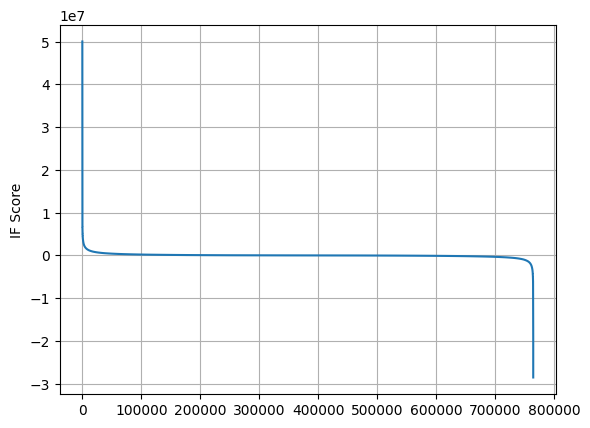

Query Sequence:
Text: 

Completion: the toys on the table

Top Positive Influential Sequences:
Rank = 0; Score = 50069504.0
she's full of digadigadigadiga digadigadigadiga digadigadigadiga ?
Rank = 1; Score = 23461888.0
mosquitoes can't come in .
Rank = 2; Score = 21364736.0
gonna getcher feet gonna getcher feet .
Rank = 3; Score = 18743296.0
they have left their overcoats jackets or capes boots or rubbers mittens or gloves some scarves many hats few earmuffs backstage in dark green metal lockers .
Rank = 4; Score = 18350080.0
where the watermelons ?
Rank = 5; Score = 15597568.0
gonna getcher nose i'm gonna getcher nose i gotcher nose i got it ?
Rank = 6; Score = 14614528.0
ih ih ih ih ih ih ih ih .
Rank = 7; Score = 14483456.0
alphabits cereal ?
Rank = 8; Score = 14417920.0
oinkoinkoink .
Rank = 9; Score = 13959168.0
trowbridge cambridge street ?
Top Negative Influential Sequences:
Rank = -1; Score = -28573696.0
wed wednesday tue tue .
Rank = -2; Score = -25821184.0
and a hum came sud

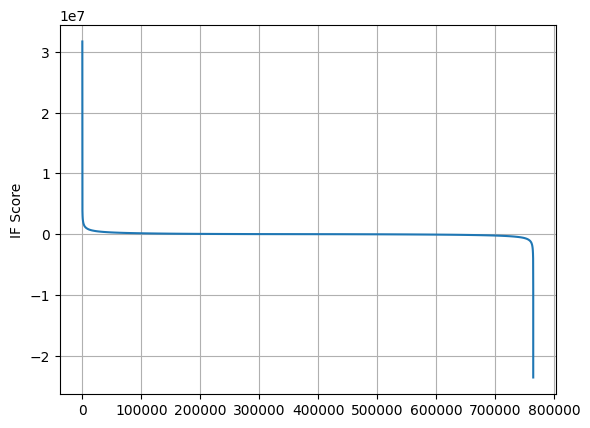

Query Sequence:
Text: the toys on the table

Completion: are

Top Positive Influential Sequences:
Rank = 0; Score = 31719424.0
she's full of digadigadigadiga digadigadigadiga digadigadigadiga ?
Rank = 1; Score = 16711680.0
yeah but i don't think they're having the ice cream social anymore .
Rank = 2; Score = 12845056.0
june i don't think we can puttaputta any more on this ?
Rank = 3; Score = 11993088.0
hah let's see my parents like the temple of dendoor best you walk right up to it and see the hieroglyphics on the walls and graffiti that the original explorers wrote there too .
Rank = 4; Score = 9830400.0
oh i don't think that smurf comes out of the car honey ?
Rank = 5; Score = 8257536.0
well if you if you throw the seeds on soft plowed earth then they grow better than if you sow them on hard caked earth .
Rank = 6; Score = 7864320.0
before she left the ball she received a warning though on the stroke of midnight the spell will be broken the fairy godmother told her and everything wil

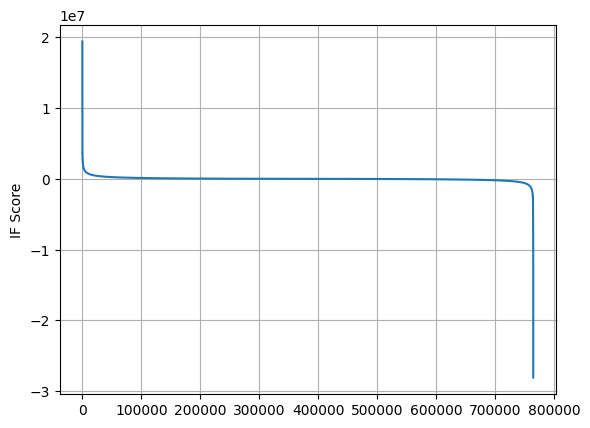

Query Sequence:
Text: the toys on the table

Completion: is

Top Positive Influential Sequences:
Rank = 0; Score = 19398656.0
whydally okay whydally .
Rank = 1; Score = 18087936.0
you may laugh at that but when i tell my friend secret she can talk all she wants but no one can understand her except another chicken of course my chicken not only listens to my stories she has other uses if you play with her and take her mind off of what's going on you can quickly very quickly snatch a feather or two when she's distracted she doesn't notice and feathers come in handy later of course ?
Rank = 2; Score = 12648448.0
i was like look at how chubby she is she has the chubbiest cheeks .
Rank = 3; Score = 12582912.0
she also thinks that um i might have told you when we were in ireland we were looking at the moon and the cloud moved in front of it so we kept saying so we kept saying the moon's hiding behind the cloud so a lot of times now she'll point to clouds and say moon because she thinks the mo

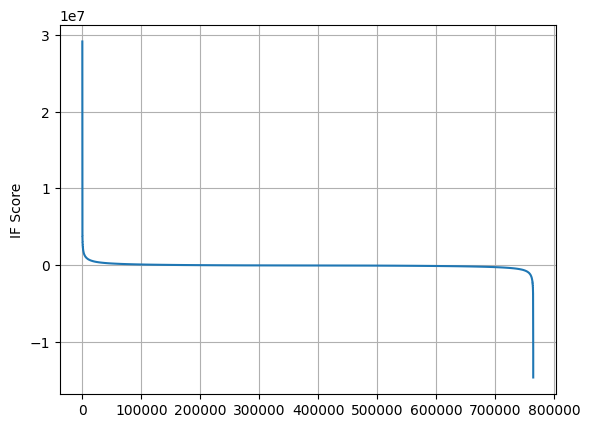

Query Sequence:
Text: 

Completion: i think the toy on the table

Top Positive Influential Sequences:
Rank = 0; Score = 29097984.0
she's full of digadigadigadiga digadigadigadiga digadigadigadiga ?
Rank = 1; Score = 13172736.0
hah let's see my parents like the temple of dendoor best you walk right up to it and see the hieroglyphics on the walls and graffiti that the original explorers wrote there too .
Rank = 2; Score = 12058624.0
cootchy cootchy cootchy ?
Rank = 3; Score = 10747904.0
we have a little chicken tikka sauce and i wonder if we could make a vinaigrette out of this although this sauce does not excite me so much but we could probably do that right ?
Rank = 4; Score = 9043968.0
so i i talked it over with nunan who called up a couple of days after ralph and i discussed it o on something else .
Rank = 5; Score = 8847360.0
although its slow progress made the giant sloth an easy target for meat eaters its claws served as effective weapons .
Rank = 6; Score = 8650752.0
motivated de

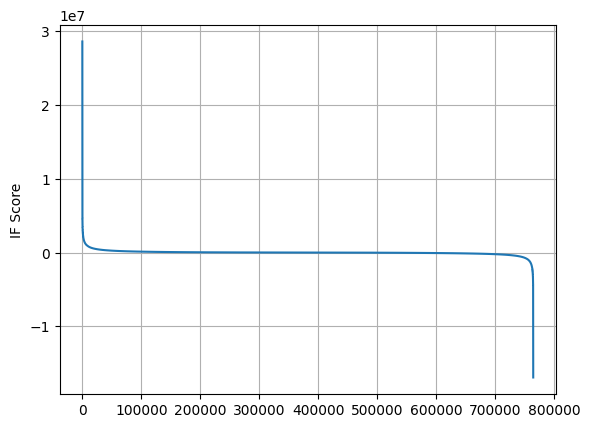

Query Sequence:
Text: i think the toy on the table

Completion: is

Top Positive Influential Sequences:
Rank = 0; Score = 28573696.0
she's full of digadigadigadiga digadigadigadiga digadigadigadiga ?
Rank = 1; Score = 15073280.0
down by the bay where the watermelons grow back to my home i dare not go for if i do my mother will say did you ever see an apple wearing a bapple did you ever see an orange eating a blouse did you ever have a time when you couldn't make a rhyme down by the bay .
Rank = 2; Score = 14548992.0
and i i came home and she said that he was itching so i looked and he had hives and that's the typical you know it's not like a severe bright red he's not throwing up it's not like a severe reaction but he he's obviously having a reaction and i don't know if i .
Rank = 3; Score = 13893632.0
i um was trying to tell her not to eat the dirty snow and i opened the passenger side and whacked myself in the head with the i don't know if you can tell i have a big like lump on my he

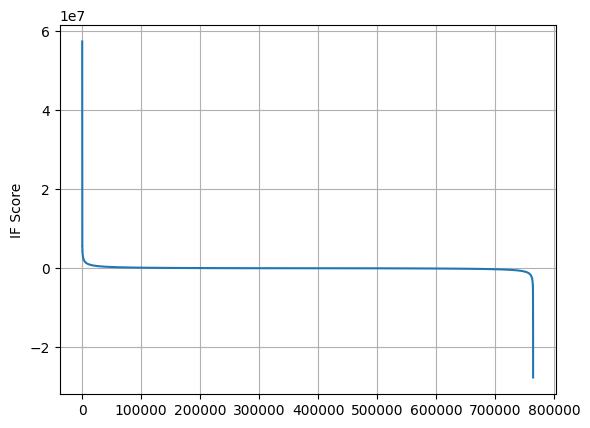

Query Sequence:
Text: i think the toy on the table

Completion: are

Top Positive Influential Sequences:
Rank = 0; Score = 57409536.0
oh do you think he has to go to the dentist and have the dentist put his teeth back in .
Rank = 1; Score = 35913728.0
she's full of digadigadigadiga digadigadigadiga digadigadigadiga ?
Rank = 2; Score = 31588352.0
what all did you do when you went to see grandma and grandma and aunt angie ?
Rank = 3; Score = 25952256.0
gonna getcher feet gonna getcher feet .
Rank = 4; Score = 23986176.0
then she heard a bug cry i'm stuck in a spout and she climbed to the top and hoisted him out .
Rank = 5; Score = 19791872.0
old mother hubbard went to the cupboard to get her poor doggie a bone ?
Rank = 6; Score = 18743296.0
gonna getcher nose i'm gonna getcher nose i gotcher nose i got it ?
Rank = 7; Score = 17694720.0
this is that's usually how she spends like a good i would say she'll have a good pocket of maybe an hour in the afternoon or an hour in the morning hour i

In [12]:
# Qualitative Showcase
qualitative(attn_scores, eval_dataset, M)

Processing Pair: Eval 0 and Eval 1
Metrics:
Spearman: 0.0085
Kendall: 0.0057


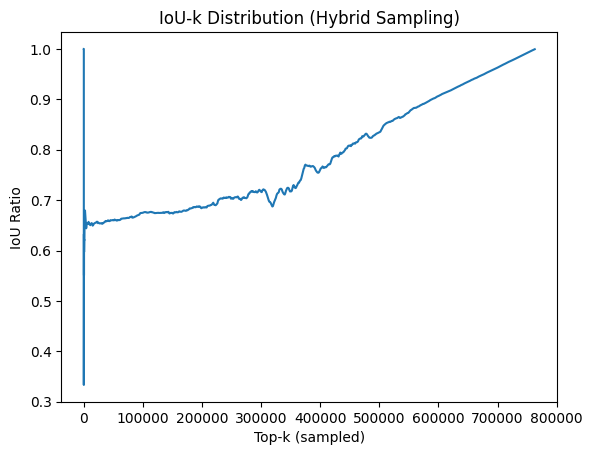

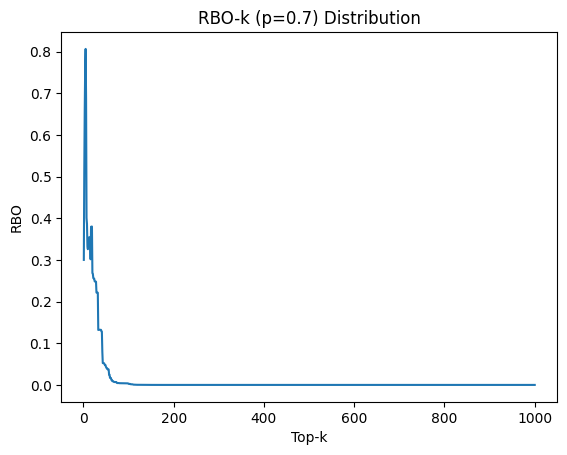

Processing Pair: Eval 2 and Eval 3
Metrics:
Spearman: 0.0083
Kendall: 0.0055


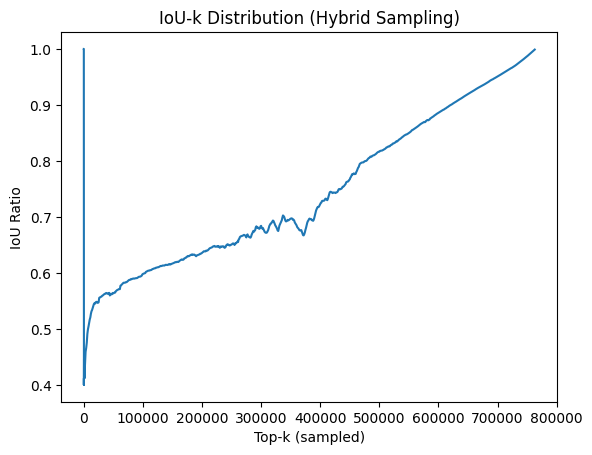

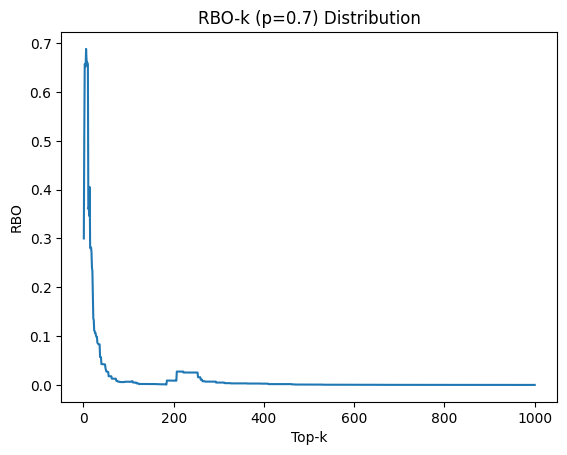

In [5]:
quantitative(attn_scores)